## これからやること！！

内容としては、「バルニバービ」というレストランを経営している上場企業の分析をオープンソースを使ってやろうと思っています。
詳しい内容をいうと、twitter・yahoofinance・HPからのスクレイピングの後、それで得た店の位置データ・会社の財務データによってそのビジネスを可視化し、twitterなどのSNSで取って来た言語（顧客の感想）データをword2vecで分析することによって、最終的には今後の出店や売上・利益の予測を行い投資判断を下すところまでやろうと思っています。
実は、もうmapデータや財務データは処理しているので、これからやるタスクはword2vecによる顧客の感想の分析です。まだ使ったことのないライブラリなので、もしかしたらうまくいかずに別のアプローチに切り替えるかもしれません。

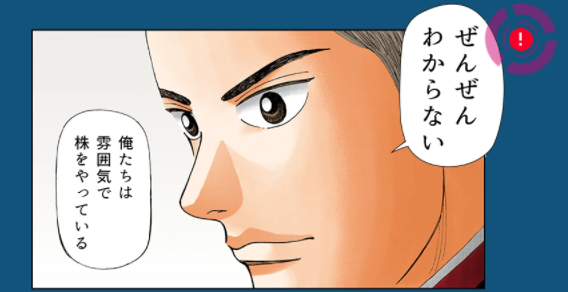

## まずは店のデータを得るよー！！

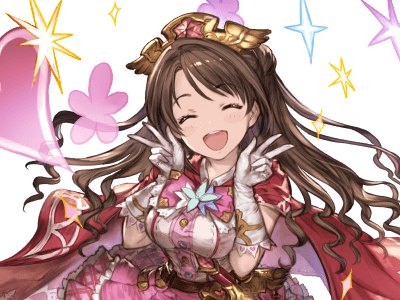

これが店のデータ↓店の場所、席の数がわかる。
http://www.balnibarbi.com/shops/

こっちがカテゴリー別の店データ。
http://www.balnibarbi.com/shops/east.php

店の平均予算、評価（食べログ）
https://tabelog.com/rstLst/?vs=1&sa=&sk=GOODMORNINGCAFE&lid=top_navi1&vac_net=&svd=20171106&svt=1900&svps=2&hfc=1&sw=GOODMORNINGCAFE

これが店の平均予算↓（ぐるなび）
https://r.gnavi.co.jp/kbwj617/

これが顧客の平均評価↓（tripadvisor）
https://www.tripadvisor.jp/Restaurant_Review-g1021277-d6055125-Reviews-Garb_Enoshima-Fujisawa_Kanagawa_Prefecture_Kanto.html

1. 店の地図データとかを取って来ます。

カテゴリー別で客単価が違うので、「東日本のレストラン」みたいな店が指定しているカテゴリーごとにデータ処理していきます。

In [4]:
import requests
import lxml.html

In [5]:
from xml.etree.ElementTree import *

In [6]:
session = requests.Session()
response = session.get('http://www.balnibarbi.com/shops/east.php')
urls = list()
root = lxml.html.fromstring(response.content)
root.make_links_absolute(response.url)  
for a in root.cssselect('a'):
    url = a.get("href")
    urls.append(url)

In [7]:
i = 0
ipc = list()
for i in range(len(urls)):
    if "shops" in urls[i]:
               ipc.append(urls[i])
    else:
               pass
ipcs = ipc[1:]
ipcl = ipcs[12:-2]

ここまでで、「東日本のレストラン」カテゴリーに属する店のurlだけを全て取ってくることができました。これから、こんな感じ⇨（http://www.balnibarbi.com/shops/garb_t/）　の店の個別ページに飛んで、店の名前、場所、席数を取って来ます。

In [8]:
import re
session = requests.Session()
i = 0
dic = dict()
lis = list()
lis2 = list()
for url in ipcl:
    response = session.get(url)
    root = lxml.html.fromstring(response.content)
    for x in root.cssselect('h3[class ="H3_shopinfo"]'):
        lis.append(x.text)

In [9]:
lis2= list()
lis3=list()
i=0
for url in ipcl:
    response = session.get(url)
    root = lxml.html.fromstring(response.content)
    for y in root.cssselect('p'):
        lis2.append(y.text)

素直にやると、nonetype objectでnot iterateになるので、strで文字化して住所を取ってきます。

In [10]:
i = 0
q = 0
lis3=list()
lis4= list()
for i in range(len(lis2)):
    l = str(lis2[i])
    if "〒" in l:
        lis3.append(l)
for q in range(len(lis3)):
    l = lis3[q]
    ls = l[10:-1]
    lis4.append(ls)
lis4

['東京都千代田区丸の内2-2-3 丸の内仲通りビル1F',
 '東京都千代田区神田錦町3-22 テラススクエア 2F',
 '東京都千代田区紀尾井町1-3 東京ガーデンテラス紀尾井町1F',
 '東京都千代田区神田錦町3-22 テラススクエア1F',
 '東京都渋谷区千駄ヶ谷5-24-3 NTTドコモアネックスＩ-3F',
 '東京都千代田区丸の内2-7-3 東京TOKIAビルB1F',
 '東京都文京区小石川3-32-1 小石川ピアット2F',
 '東京都文京区小石川3-32-1 小石川ピアット1F',
 '東京都千代田区有楽町2-7-1 有楽町マルイ3F',
 '東京都豊島区西池袋1-11-1 ルミネ池袋8F イケレス',
 '東京都中野区中野4-10-2\u3000中野セントラルパークサウス 1F',
 '東京都千代田区神田錦町3-20\u3000錦町トラッドスクエア1F',
 '東京都港区港南1-2-70 品川シーズンテラス 2Ｆ',
 '東京都渋谷区千駄ヶ谷1-17-1 東京体育館プール棟',
 '東京都新宿区西早稲田1-9-12 大隈スクエアビル １Ｆ',
 '東京都港区西新橋2-16-6',
 '東京都渋谷区神宮前6-28-6 キュープラザ原宿 3F',
 '東京都台東区蔵前2-15-5 MIRROR 1F',
 '東京都墨田区江東橋3-14-5\u3000テルミナ 5F ',
 '東京都台東区蔵前2-15-5 MIRROR 4F',
 '東京都 台東区 駒形2-1-7 MKビル 1F',
 '台東区駒形2-1-7 MKビル3F',
 '東京都 台東区 駒形2-1-7 MKビル 4F',
 '東京都台東区蔵前2-15-5 MIRROR 7F',
 '東京都渋谷区恵比寿4-4-7',
 '東京都足立区千住東1-29-12',
 '東京都足立区千住東1-29-12',
 '東京都墨田区横網1-12-21',
 '東京都千代田区神田錦町2-3-10',
 '東京都港区芝浦3-4-1田町グランパーク 1F',
 '新宿区大久保3-8-4 住友不動産新宿ガーデンタワーアネックス2F',
 '東京都墨田区横網1-12-21',
 '東京都台東区蔵前2-15-5 1,2,3F',
 '神奈川県藤沢市片瀬海岸2-17-23 THE BEACH HOUSE 2F',


次に席数をとります。

In [11]:
lis2 = list()
lis3= list()
q = 0
for url in ipcl:
    response = session.get(url)
    root = lxml.html.fromstring(response.content)
    for y in root.cssselect('p[class ="shopSeat"]'):
        lis2.append(y.text)
for q in range(len(lis2)):
    l = lis2[q]
    ls = l[4:8]
    lis3.append(ls)
lis3.insert(31, 0)
lis3.insert(32, 0)

In [12]:
i = 0
lis5 = list()
for i in range(len(lis3)):
    l = str(lis3[i])
    ls = l.replace('\n', '')
    lss = ls.replace('全', '')
    lsss = lss.replace('席', '')
    lis5.append(lsss)
lis5

['98',
 '96',
 '116',
 '76',
 '115',
 '25',
 '134',
 '22',
 '81',
 '77',
 '110',
 '143',
 '124',
 '117',
 '80',
 '108',
 '84',
 '307',
 '85',
 '60',
 '86',
 '18',
 '17',
 '75',
 '60',
 '87',
 '47',
 '155',
 '30',
 '103',
 '92',
 '0',
 '0',
 '183',
 '0',
 '195',
 '126']

次に、店の名前を取って来ます。

In [13]:
erl =list()
i= 0
for i in range(len(lis)):
    l = lis[i]
    la = l[1:-2]
    erl.append(la)

In [14]:
print(erl, lis5, lis4)

['GARB Tokyo', 'GARB pintino', 'GARB CENTRAL', '鉄板チャイニーズバル Cava？', '本家かのや', '鹿児島 かのや萩原', 'AOI NAPOLI', '青いナポリ Blue Bar', 'Skew', 'GOOD MORNING CAFE ルミネ池袋', 'GOOD MORNING CAF', 'GOOD MORNING CAFE 錦町', 'GOOD MORNING CAFE 品川シーズンテラス', 'GOOD MORNING CAFE 千駄ヶ谷', 'GOOD MORNING CAFE 早稲田', 'GOOD MORNING CAFE & GRILL 虎ノ門', 'GOOD MORNING CAFE & GRILL キュウリ', 'Riverside Cafe Cielo y Rio', 'Cielo y Rio HIGASHI', 'RIBAYON', 'ボン花火', 'BistroBar TROIS CUIT ASANUMA', 'BAR RIVER ROOM KURAKOMA', 'Privado', "L'Antica Pizzeria da Michele", "AD'ACCHIO", 'SLOW JET COFFEE', '両国テラスカフェ', '神田錦町 如月', 'Wee Nam Kee Hainanese Chicken Rice', 'Cucina Caffe OLIVA', '両国テラス', 'MIRROR', 'GARB 江ノ島', 'TOYOTAMA VILLA', 'UPMARKET PIZZA&CAFE', 'OPEN TERRACE ME-EAT'] ['98', '96', '116', '76', '115', '25', '134', '22', '81', '77', '110', '143', '124', '117', '80', '108', '84', '307', '85', '60', '86', '18', '17', '75', '60', '87', '47', '155', '30', '103', '92', '0', '0', '183', '0', '195', '126'] ['東京都千代田区丸の内2-2-3 丸の内仲通りビル1F', '東

In [93]:
de = dict()
de2 = dict()
i = 0
for i in range(len(erl)):
    de.update({erl[i]:lis5[i]})
    de2.update({erl[i]:lis4[i]})
de

{"AD'ACCHIO": '87',
 'AOI NAPOLI': '134',
 'BAR RIVER ROOM KURAKOMA': '17',
 'BistroBar TROIS CUIT ASANUMA': '18',
 'Cielo y Rio HIGASHI': '85',
 'Cucina Caffe OLIVA': '92',
 'GARB CENTRAL': '116',
 'GARB Tokyo': '98',
 'GARB pintino': '96',
 'GARB 江ノ島': '183',
 'GOOD MORNING CAF': '110',
 'GOOD MORNING CAFE & GRILL キュウリ': '84',
 'GOOD MORNING CAFE & GRILL 虎ノ門': '108',
 'GOOD MORNING CAFE ルミネ池袋': '77',
 'GOOD MORNING CAFE 千駄ヶ谷': '117',
 'GOOD MORNING CAFE 品川シーズンテラス': '124',
 'GOOD MORNING CAFE 早稲田': '80',
 'GOOD MORNING CAFE 錦町': '143',
 "L'Antica Pizzeria da Michele": '60',
 'MIRROR': '0',
 'OPEN TERRACE ME-EAT': '126',
 'Privado': '75',
 'RIBAYON': '60',
 'Riverside Cafe Cielo y Rio': '307',
 'SLOW JET COFFEE': '47',
 'Skew': '81',
 'TOYOTAMA VILLA': '0',
 'UPMARKET PIZZA&CAFE': '195',
 'Wee Nam Kee Hainanese Chicken Rice': '103',
 'ボン花火': '86',
 '両国テラス': '0',
 '両国テラスカフェ': '155',
 '本家かのや': '115',
 '神田錦町 如月': '30',
 '鉄板チャイニーズバル Cava？': '76',
 '青いナポリ Blue Bar': '22',
 '鹿児島 かのや萩原': '25'

席数が０になっているノイズについて。
MIRRORは、商業施設そのものの名前なので、席数は０になっている。中にはRiverside Cafe Cielo y RioとRIBAYONとPrivadoが含まれている。両国テラスも、両国テラスカフェと同一だから０。トヨタマヴィラは施設の名前で中にあるのがUPMARKET PIZZA&CAFE。

In [94]:
de2

{"AD'ACCHIO": '東京都足立区千住東1-29-12',
 'AOI NAPOLI': '東京都文京区小石川3-32-1 小石川ピアット2F',
 'BAR RIVER ROOM KURAKOMA': '東京都 台東区 駒形2-1-7 MKビル 4F',
 'BistroBar TROIS CUIT ASANUMA': '台東区駒形2-1-7 MKビル3F',
 'Cielo y Rio HIGASHI': '東京都墨田区江東橋3-14-5\u3000テルミナ 5F ',
 'Cucina Caffe OLIVA': '新宿区大久保3-8-4 住友不動産新宿ガーデンタワーアネックス2F',
 'GARB CENTRAL': '東京都千代田区紀尾井町1-3 東京ガーデンテラス紀尾井町1F',
 'GARB Tokyo': '東京都千代田区丸の内2-2-3 丸の内仲通りビル1F',
 'GARB pintino': '東京都千代田区神田錦町3-22 テラススクエア 2F',
 'GARB 江ノ島': '神奈川県藤沢市片瀬海岸2-17-23 THE BEACH HOUSE 2F',
 'GOOD MORNING CAF': '東京都中野区中野4-10-2\u3000中野セントラルパークサウス 1F',
 'GOOD MORNING CAFE & GRILL キュウリ': '東京都渋谷区神宮前6-28-6 キュープラザ原宿 3F',
 'GOOD MORNING CAFE & GRILL 虎ノ門': '東京都港区西新橋2-16-6',
 'GOOD MORNING CAFE ルミネ池袋': '東京都豊島区西池袋1-11-1 ルミネ池袋8F イケレス',
 'GOOD MORNING CAFE 千駄ヶ谷': '東京都渋谷区千駄ヶ谷1-17-1 東京体育館プール棟',
 'GOOD MORNING CAFE 品川シーズンテラス': '東京都港区港南1-2-70 品川シーズンテラス 2Ｆ',
 'GOOD MORNING CAFE 早稲田': '東京都新宿区西早稲田1-9-12 大隈スクエアビル １Ｆ',
 'GOOD MORNING CAFE 錦町': '東京都千代田区神田錦町3-20\u3000錦町トラッドスクエア1F',
 "L'Antica Pizzeria d

東日本のレストランの名前、場所、席数をリスト化することができたので、同じことを関数化して西日本のレストラン、スイーツショップ、アスリート食堂についても同じ処理を繰り返します。まずは店の名前の関数から。

In [17]:
def shop_name(x):
    session = requests.Session()
    response = session.get(x)
    urls = list()
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)  
    for a in root.cssselect('a'):
        url = a.get("href")
        urls.append(url)
    i = 0
    ipc = list()
    for i in range(len(urls)):
        if "shops" in urls[i]:
                   ipc.append(urls[i])
        else:
                   pass
    ipcs = ipc[1:]
    ipcl = ipcs[12:-2]
    import re
    session = requests.Session()
    i = 0
    dic = dict()
    lis = list()
    lis2 = list()
    for url in ipcl:
        response = session.get(url)
        root = lxml.html.fromstring(response.content)
        for x in root.cssselect('h3[class ="H3_shopinfo"]'):
            lis.append(x.text)
    wrl =list()
    i= 0
    for i in range(len(lis)):
        l = lis[i]
        la = l[1:-2]
        wrl.append(la)
    wrl
    return wrl

In [20]:
wrl = list()
wrl = shop_name("http://www.balnibarbi.com/shops/west.php")

In [24]:
wrl

['Hamac de Paradis',
 'CAFE GARB',
 'monochrome',
 'AOI NAPOLI IN THE PARK',
 'GARB DRESSING',
 '鹿児島 かのや篠原',
 'MOULiN',
 'BARKT',
 'GARB weeks',
 'NAKANOSHIMA SOCIAL EAT AWAKE',
 'NAKANOSHIMA OPEN TERRACE',
 'CUORERUDINO',
 'Hamac de Paradis ICC',
 'MEAL TOGETHER ROOF TERRACE',
 'Chandelier Table',
 'GARB MONAQUE',
 'FRENCH BAGUETTE CAFÉ',
 'The LOAF Cafe',
 'LOAF Bakery',
 'GARB CASTELLO',
 'MU GARDEN TERRACE',
 'Hamac de Paradis 寒梅館',
 'Hamac de Paradis Latte',
 'IN THE GREEN',
 'OBU CAFE',
 'SLOW JET COFFEE IN THE ZOO',
 'SLOW JET COFFEE KODAI-JI',
 'IN THE GREEN GARDENS',
 "SUNDAY'S BAKE RIVER GARDEN",
 'THE CALENDAR',
 'CALENDAR HOTEL',
 'GARB LEAVES',
 "L'Antica Pizzeria da Michele 福岡",
 'CAFÉ ETRANGER NARAD',
 'ORANGE BALCONY']

In [58]:
len(wrl)

35

次に店の住所の関数。

In [31]:
def shop_address(x):
    session = requests.Session()
    response = session.get(x)
    urls = list()
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)  
    for a in root.cssselect('a'):
        url = a.get("href")
        urls.append(url)
    i = 0
    ipc = list()
    for i in range(len(urls)):
        if "shops" in urls[i]:
                   ipc.append(urls[i])
        else:
                   pass
    ipcs = ipc[1:]
    ipcl = ipcs[12:-2]
    import re
    lis2= list()
    lis3=list()
    i=0
    for url in ipcl:
        response = session.get(url)
        root = lxml.html.fromstring(response.content)
        for y in root.cssselect('p'):
            lis2.append(y.text)
    i = 0
    q = 0
    lis3=list()
    lis4= list()
    for i in range(len(lis2)):
        l = str(lis2[i])
        if "〒" in l:
            lis3.append(l)
    for q in range(len(lis3)):
        l = lis3[q]
        ls = l[10:-1]
        lis4.append(ls)
    return lis4

In [32]:
wad = list()
wad = shop_address("http://www.balnibarbi.com/shops/west.php")

In [33]:
print(wad)

['大阪市中央区南船場4-12-21', '大阪市中央区博労町4-4-7', '大阪市天王寺区悲田院町10-39 ＭIO駐車場ビル 2Ｆ', '大阪市天王寺区茶臼山町5-55 てんしば', '大阪市都島区東野田町1-2-1 京阪京橋高架街\n', '大阪市中央区平野町4-5-5', '大阪市西区南堀江1-5-26 キャナルテラス 1F', '大阪市中央区宗右衛門町5-15 ホリデイ・イン大阪難波', '大阪市北区中之島1-1-29 中之島公園内', '大阪市北区中之島1-1-27\u3000大阪市中央公会堂 B１F', '大阪市北区中之島1 中之島公園内（大阪市役所南側）', '大阪市西区南堀江1-14-26 1F', '大阪府枚方市中宮東之町16-1 関西外国語大学ＩＣＣ 1F', '大阪府枚方市岡東町12-2 枚方T-SITE 8F', '大阪市北区角田町8-7 阪急うめだ本店 13F', '大阪市北区大深町4-1 グランフロント大阪 うめきた広場 1F', '大阪府大阪市中央区淡路町3-5-13', '大阪府豊中市清風荘2-4-23', '大阪府豊中市清風荘2-4-23', '愛知県名古屋市北区名城1-4-1 名城公園内 tonarino1F', '名古屋市東区矢田南 4-102-9\n名城大学ナゴヤドーム前キャンパス北館1F', '京都府京都市上京区烏丸通上立売下ル御所八幡町103 同志社大学寒梅館 1F', '京田辺市多々羅都谷1-3 同志社大学京田辺キャンパス', '京都市左京区下鴨半木町 府立植物園北山門横', '京都市右京区嵯峨天龍寺造路町20-1 京福嵐山駅はんなりほっこりスクエア 2F', '京都市左京区岡崎法勝寺町岡崎公園内京都市動物園正面エントランス内', '京都市東山区高台寺下河原町526 高台寺境内', '兵庫県西宮市高松町14-2 阪急西宮ガーデンズ4F', '滋賀県草津市大路1-3-18-3クサツココリバ内\n「サンデーズベイク リバーガーデン」', '大津市春日町1-3 ビエラ大津', '大津市春日町1-3 ビエラ大津', '福岡県福岡市博多区博多駅前3-19-1', '福岡市中央区大名1-4-18', '奈良市上三条町23-4 奈良市観光センター「ナラニクル」内', '滋賀県守山市今浜町2620-5 ピエリ守山2F']


In [57]:
len(wad)

35

最後に店の席数の関数を作ります。

In [73]:
def shop_seat(x):
    session = requests.Session()
    response = session.get(x)
    urls = list()
    root = lxml.html.fromstring(response.content)
    root.make_links_absolute(response.url)  
    for a in root.cssselect('a'):
        url = a.get("href")
        urls.append(url)
    i = 0
    q=0
    ipc = list()
    lis2=list()
    for i in range(len(urls)):
        if "shops" in urls[i]:
            ipc.append(urls[i])
        else:
            pass
    ipcs = ipc[1:]
    ipcl = ipcs[12:-2]
    for url in ipcl:
        response = session.get(url)
        root = lxml.html.fromstring(response.content)
        for y in root.cssselect('p'):
            lis2.append(y.text)
    i = 0
    q = 0
    lis3=list()
    lis4= list()
    for i in range(len(lis2)):
        l = str(lis2[i])
        if "席数" in l:
            lis3.append(l)
    for q in range(len(lis3)):
        l = lis3[q]
        lis4.append(l)
    i = 0
    lis5 = list()
    for i in range(len(lis4)):
        l = str(lis4[i])
        ls = l.replace('\n', '')
        lss = ls.replace('全', '')
        lsss = lss.replace('席数', '')
        lssss = lsss.replace('／', '')
        ld = lssss.replace(' ','')
        lc = ld.replace('席','')
        lis5.append(lc)
    return lis5

In [119]:
ws = shop_seat("http://www.balnibarbi.com/shops/west.php")

In [120]:
ws

['138',
 '402',
 '109',
 '200',
 '270',
 '40',
 '182',
 '88',
 '160',
 '149',
 '105',
 '137',
 '180',
 '350',
 '130',
 '68',
 '210',
 '230',
 '346',
 '136',
 '120',
 '136',
 '68',
 '82',
 '76',
 '130',
 '240',
 '226',
 '78',
 '145',
 '100']

ノイズは、期間限定だったため終了しているNAKANOSHIMA OPEN TERRACEと、レストランではなくホテルであるCALENDAR HOTELと、０席のSLOW JET COFFEE IN THE ZOO（９）と、純粋にパン屋で０席のLOAF Bakeryが原因なので、調整する。

In [121]:
ws.insert(10, 0)
ws.insert(18, 0)
ws.insert(25, 0)
ws.insert(30, 0)
ws

['138',
 '402',
 '109',
 '200',
 '270',
 '40',
 '182',
 '88',
 '160',
 '149',
 0,
 '105',
 '137',
 '180',
 '350',
 '130',
 '68',
 '210',
 0,
 '230',
 '346',
 '136',
 '120',
 '136',
 '68',
 0,
 '82',
 '76',
 '130',
 '240',
 0,
 '226',
 '78',
 '145',
 '100']

In [122]:
len(ws)

35

関数ができたので、アスリート食堂とスイーツショップについても同じ処理を繰り返します（ただし、席数は手で入力する）

In [131]:
arl = list()
aad = list()
aas = list()
arl =  shop_name("http://www.balnibarbi.com/shops/asushoku.php")
aad = shop_address("http://www.balnibarbi.com/shops/asushoku.php")
aas  = [49,34,0,28,92,96]

In [130]:
srl = list()
sad = list()
ss = list()
srl =  shop_name("http://www.balnibarbi.com/shops/sweets.php")
sad = shop_address("http://www.balnibarbi.com/shops/sweets.php")
ss  = [0,0,22,0,0,0,0,0]

さて、これで店の名前・場所・席数を揃えられました。pandas.DataFrameでわかりやすい表にしたら、このfileでの作業は終わりです。

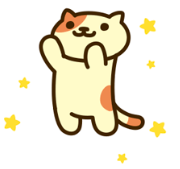

In [79]:
import pandas as pd
from pandas import DataFrame as df

In [97]:
de4 = df([de])
de5 = df([de2])

In [136]:
p = pd.concat([de5, de4])

In [137]:
p1 = p.T

In [149]:
p1

,0,0
AD'ACCHIO,東京都足立区千住東1-29-12,87
AOI NAPOLI,東京都文京区小石川3-32-1 小石川ピアット2F,134
BAR RIVER ROOM KURAKOMA,東京都 台東区 駒形2-1-7 MKビル 4F,17
BistroBar TROIS CUIT ASANUMA,台東区駒形2-1-7 MKビル3F,18
Cielo y Rio HIGASHI,東京都墨田区江東橋3-14-5 テルミナ 5F,85
Cucina Caffe OLIVA,新宿区大久保3-8-4 住友不動産新宿ガーデンタワーアネックス2F,92
GARB CENTRAL,東京都千代田区紀尾井町1-3 東京ガーデンテラス紀尾井町1F,116
GARB Tokyo,東京都千代田区丸の内2-2-3 丸の内仲通りビル1F,98
GARB pintino,東京都千代田区神田錦町3-22 テラススクエア 2F,96
GARB 江ノ島,神奈川県藤沢市片瀬海岸2-17-23 THE BEACH HOUSE 2F,183


In [123]:
dw = dict()
dw2 = dict()
i = 0
for i in range(len(wrl)):
    dw.update({wrl[i]:wad[i]})
    dw2.update({wrl[i]:ws[i]})
dfw = df([dw])
dfw2 = df([dw2])
pw = pd.concat([dfw, dfw2])
p2 = pw.T

In [148]:
p2

,0,0
AOI NAPOLI IN THE PARK,大阪市天王寺区茶臼山町5-55 てんしば,200
BARKT,大阪市中央区宗右衛門町5-15 ホリデイ・イン大阪難波,88
CAFE GARB,大阪市中央区博労町4-4-7,402
CAFÉ ETRANGER NARAD,奈良市上三条町23-4 奈良市観光センター「ナラニクル」内,145
CALENDAR HOTEL,大津市春日町1-3 ビエラ大津,0
CUORERUDINO,大阪市西区南堀江1-14-26 1F,105
Chandelier Table,大阪市北区角田町8-7 阪急うめだ本店 13F,350
FRENCH BAGUETTE CAFÉ,大阪府大阪市中央区淡路町3-5-13,68
GARB CASTELLO,愛知県名古屋市北区名城1-4-1 名城公園内 tonarino1F,230
GARB DRESSING,大阪市都島区東野田町1-2-1 京阪京橋高架街\n,270


In [132]:
da = dict()
da2 = dict()
i = 0
for i in range(len(arl)):
    da.update({arl[i]:aad[i]})
    da2.update({arl[i]:aas[i]})
dfa = df([da])
dfa2 = df([da2])
pa = pd.concat([dfa, dfa2])
p3 = pa.T

In [133]:
p3

,0,0
バランス食堂＆カフェ アスショク,大阪市中央区森ノ宮中央2-1-70 もりのみやキューズモールBASE 1F,92
鹿屋アスリート食堂 両国テラス,東京都墨田区横網1-12-21,0
鹿屋アスリート食堂 丸の内,東京都千代田区丸の内3-1-1 国際ビルB1F,34
鹿屋アスリート食堂 品川シーズンテラス,東京都港区港南1-2-70 品川シーズンテラス1F,28
鹿屋アスリート食堂 本店,東京都千代田区神田錦町3-21 10 OVER 9 1F,49
鹿屋アスリート食堂 研究開発本部,鹿児島県鹿屋市古里町594-1,96


In [134]:
ds = dict()
ds2 = dict()
i = 0
for i in range(len(srl)):
    ds.update({srl[i]:sad[i]})
    ds2.update({srl[i]:ss[i]})
dfs = df([ds])
dfs2 = df([ds2])
ps = pd.concat([dfs, dfs2])
p4 = ps.T

In [142]:
pp = pd.concat([p1,p2,p3,p4])
pp.columns = ['address', 'seat']
pp

,address,seat
AD'ACCHIO,東京都足立区千住東1-29-12,87
AOI NAPOLI,東京都文京区小石川3-32-1 小石川ピアット2F,134
BAR RIVER ROOM KURAKOMA,東京都 台東区 駒形2-1-7 MKビル 4F,17
BistroBar TROIS CUIT ASANUMA,台東区駒形2-1-7 MKビル3F,18
Cielo y Rio HIGASHI,東京都墨田区江東橋3-14-5 テルミナ 5F,85
Cucina Caffe OLIVA,新宿区大久保3-8-4 住友不動産新宿ガーデンタワーアネックス2F,92
GARB CENTRAL,東京都千代田区紀尾井町1-3 東京ガーデンテラス紀尾井町1F,116
GARB Tokyo,東京都千代田区丸の内2-2-3 丸の内仲通りビル1F,98
GARB pintino,東京都千代田区神田錦町3-22 テラススクエア 2F,96
GARB 江ノ島,神奈川県藤沢市片瀬海岸2-17-23 THE BEACH HOUSE 2F,183


これで、お店のカテゴリー別にお店の名前、場所、席数のリストを取ることができました！
次に、会社のIR（investor relationship）のデータを使って、会社の財務やビジネスを入力して可視化します（ただしこれはデータがpdf形式なので手打ちでやりました）

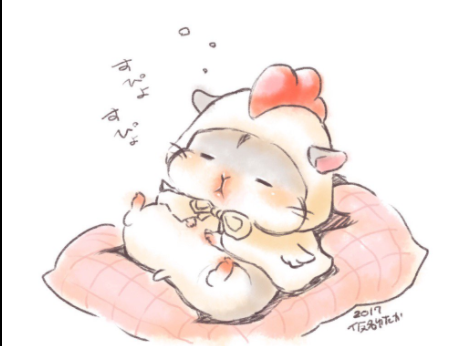

ここで、店がどういう場所にあるのかを、googlemapで複数箇所を表示させることによって、可視化してみます。

In [147]:
pl=list(pp.address)
pl

['東京都足立区千住東1-29-12',
 '東京都文京区小石川3-32-1 小石川ピアット2F',
 '東京都 台東区 駒形2-1-7 MKビル 4F',
 '台東区駒形2-1-7 MKビル3F',
 '東京都墨田区江東橋3-14-5\u3000テルミナ 5F ',
 '新宿区大久保3-8-4 住友不動産新宿ガーデンタワーアネックス2F',
 '東京都千代田区紀尾井町1-3 東京ガーデンテラス紀尾井町1F',
 '東京都千代田区丸の内2-2-3 丸の内仲通りビル1F',
 '東京都千代田区神田錦町3-22 テラススクエア 2F',
 '神奈川県藤沢市片瀬海岸2-17-23 THE BEACH HOUSE 2F',
 '東京都中野区中野4-10-2\u3000中野セントラルパークサウス 1F',
 '東京都渋谷区神宮前6-28-6 キュープラザ原宿 3F',
 '東京都港区西新橋2-16-6',
 '東京都豊島区西池袋1-11-1 ルミネ池袋8F イケレス',
 '東京都渋谷区千駄ヶ谷1-17-1 東京体育館プール棟',
 '東京都港区港南1-2-70 品川シーズンテラス 2Ｆ',
 '東京都新宿区西早稲田1-9-12 大隈スクエアビル １Ｆ',
 '東京都千代田区神田錦町3-20\u3000錦町トラッドスクエア1F',
 '東京都渋谷区恵比寿4-4-7',
 '東京都台東区蔵前2-15-5 1,2,3F',
 '茨城県水戸市南町3丁目-6',
 '東京都台東区蔵前2-15-5 MIRROR 7F',
 '東京都台東区蔵前2-15-5 MIRROR 4F',
 '東京都台東区蔵前2-15-5 MIRROR 1F',
 '東京都足立区千住東1-29-12',
 '東京都千代田区有楽町2-7-1 有楽町マルイ3F',
 '東京都練馬区豊玉中2-28-3\u3000',
 '東京都練馬区豊玉中2-28-6',
 '東京都港区芝浦3-4-1田町グランパーク 1F',
 '東京都 台東区 駒形2-1-7 MKビル 1F',
 '東京都墨田区横網1-12-21',
 '東京都墨田区横網1-12-21',
 '東京都渋谷区千駄ヶ谷5-24-3 NTTドコモアネックスＩ-3F',
 '東京都千代田区神田錦町2-3-10',
 '東京都千代田区神田錦町3-22 テラススクエア1F',

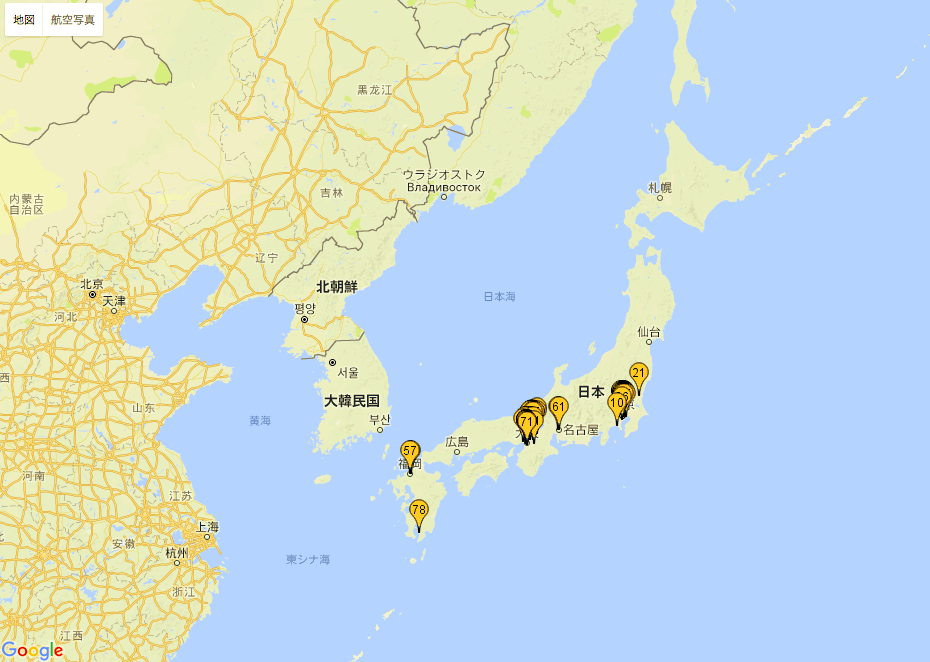

出店は日本のみで、東京都と大阪・京都に集中しています。

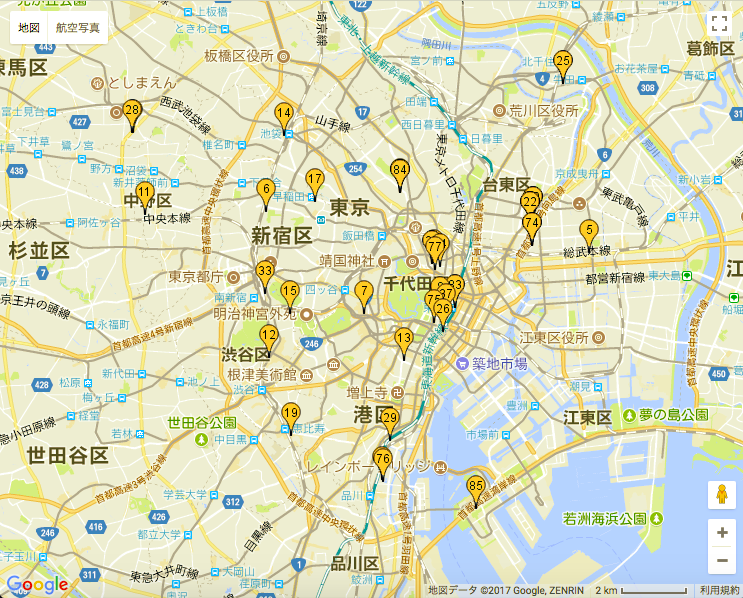

店のブランドを基本的に変えており、チェーン店ならではの「人がどのくらいいるところに何店舗まで置けるか」という問題を解決していることがわかります。集中的に狭い地域に出店しても問題ないようです。これにより、今後出店する箇所のボトルネックが少ないことが示唆されています。

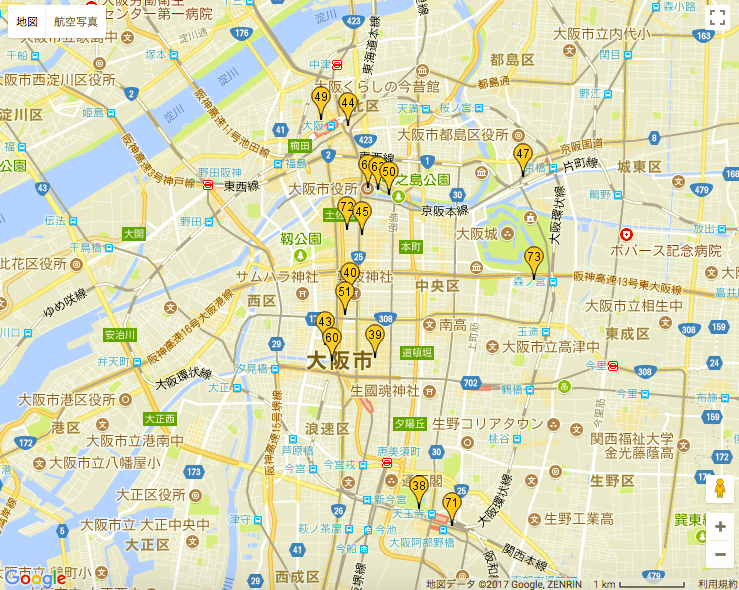

大阪でも、近い場所に集中出店できています。

出店地域の可視化が済んだので、財務分析を通してのビジネスの可視化に移ります。元データは会社のIRから出ている、有価証券報告書です。
http://v4.eir-parts.net/v4Contents/View.aspx?cat=yuho_pdf&sid=2601216

その結果、会社の財務データが詰まったexcelのファイルを作成することができました。
次回以降は、食べログ・ぐるなび・tripadvisor・twitterの言語分析を中心にやっていきます。